# Regressão logística

Vamos agora considerar o problema de *classificar* um conjunto de pessoas em adolescente ou adulto dependendo da altura.

### Leitura dos dados

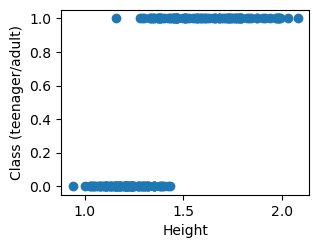

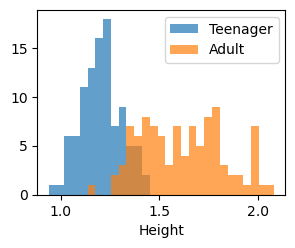

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt'))
x, targets = data.T

plt.scatter(x, targets)
plt.xlabel('Height')
plt.ylabel('Class (teenager/adult)')

bins = np.linspace(x.min(), x.max(), 30)
plt.figure()
plt.hist(x[targets==0], bins, alpha=0.7)
plt.hist(x[targets==1], bins, alpha=0.7)
plt.xlabel('Height')
plt.legend(('Teenager', 'Adult'))

### Modelo linear

Definiremos um modelo linear que possui um único valor como saída para cada valor de entrada. Uma função sigmóide é aplicada na saída do modelo para transformar os valores em probabilidades.

Incrementaremos nosso modelo em relação ao do notebook anterior para seguir a API do Pytorch que utilizaremos nas próximas aulas.

Text(0, 0.5, 'P(Adult|Height)')

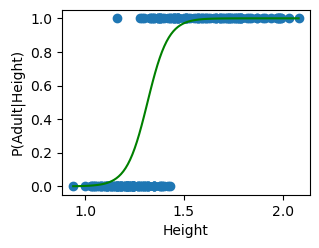

In [2]:
class Model:

    def __init__(self, a, b, requires_grad=False):

        # Parâmetros do modelo
        self.a = torch.tensor(a, requires_grad=requires_grad)
        self.b = torch.tensor(b, requires_grad=requires_grad)

    def __call__(self, x):
        y = self.a*x + self.b
        return  y
    
    def parameters(self):
        """Retorna os parâmetros do modelo."""
        return self.a, self.b

    def zero_grad(self):
        """Remove os gradientes anteriormente calculados."""
        for p in self.parameters():
            p.grad = None    
    
def sigmoid(x):
    """Recebe um valor qualquer e transforma ele para o intervalo [0,1]."""
    y = 1/(1+torch.exp(-x))
    return y

model = Model(19., -25.)
scores = model(x)
# Probabilidade de cada pessoa ser adulta
probs = sigmoid(scores)

# Cálculo das probabilidades para todas as possíveis entradas x
inputsm = torch.linspace(x.min(), x.max(), 100)
scoresm = model(inputsm)
probsm = sigmoid(scoresm)

plt.scatter(x, targets)
plt.plot(inputsm, probsm, c='g')
plt.xlabel('Height')
plt.ylabel('P(Adult|Height)')

Os valores de saída do modelo (após a aplicação da sigmóide) podem ser interpretados como a probabilidade de cada item pertencer à classe *Adulto*. 

In [3]:
#Acurácia do modelo
def acc(preds, targets):
    return torch.sum(preds==targets)/len(targets)

preds = probs>0.5
acc(preds, targets)

tensor(0.9000)

### Função de verossimilhança e entropia cruzada

Ao rotularmos os dados como classe 0 e 1, estamos dizendo que temos 100% de certeza que esses dados estão nessas classes. Portanto, na ausência de qualquer outra informação sobre os dados, o melhor modelo que podemos desenvolver para o conjunto de treinamento é tal que:

* Quando o item é da classe 0, o modelo tem como resultado P(Adult|Height)=0.0
* Quando o item é da classe 1, o modelo tem como resultado P(Adult|Height)=1.0

A função de verossimilhança e a entropia cruzada quantificam o grau de aderência do modelo a essa hipótese.

In [4]:
def prob_of_target(probs, targets):
    '''Retorna as probabilidades da classe esperada. Equivalente a
    probs_target = torch.zeros(len(probs))
    for idx, (prob, targ) in enumerate(zip(probs, targets)):
        if targ==0:
            probs_target[idx] = 1-prob
        else:
            probs_target[idx] = prob
    '''
    return probs*targets + (1-probs)*(1-targets)

def likelihood(probs, targets):
    '''Função de verossimilhança.'''
    probs_correct = prob_of_target(probs, targets)
    return torch.prod(probs_correct)

print(likelihood(probs, targets))

tensor(2.2591e-20, dtype=torch.float64)


Se o nosso modelo fosse perfeito (retornasse 0 para itens da classe 0 e 1 para itens da classe 1), a função `likelihood` acima retornaria o valor 1. 

É mais comum utilizar a função *negative log-likelihood* para evitar valores muito pequenos:

In [5]:
def nll(probs, targets):
    '''Negativo do logaritmo da função de verossimilhança'''
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)
    return -torch.sum(probs_log)

nll(probs, targets)

tensor(45.2367, dtype=torch.float64)

Nesse caso, a função `nll` daria o valor 0 (logaritmo do valor 1) para o modelo perfeito.

Para o problema de classificação que estamos estudando, uma função equivalente à `nll` é a entropia cruzada. No Pytorch, ela recebe como entrada o resultado da rede, e não as probabilidades. A função também retorna a média dos valores ao invés da soma. Então implementaremos ela dessa forma:

In [6]:
def cross_entropy(scores, targets):
    
    probs = sigmoid(scores)
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)

    return -torch.mean(probs_log)

cross_entropy(scores, targets)

tensor(0.2262, dtype=torch.float64)

### Otimização do modelo

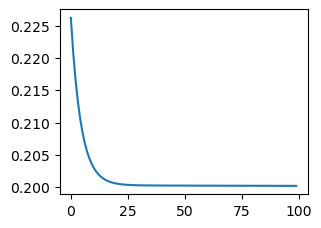

In [7]:
def step(model, x, targets, lr):

    # Apaga os gradientes
    model.zero_grad()
    scores = model(x)
    loss = cross_entropy(scores, targets)
    # Calcula os gradientes
    loss.backward()
    # Atualiza os gradientes
    with torch.no_grad():
        for p in model.parameters():
            p -= lr*p.grad

    return loss.item()

model = Model(19., -25., requires_grad=True)

num_epochs = 100
lr = 0.5
losses = []
for epoch in range(0, num_epochs):
    loss = step(model, x, targets, lr)
    losses.append(loss)

plt.plot(losses)